In [1]:
# -*- coding: utf-8 -*-
"""
Created On April 28, 2024
Last modified on April 28, 2024

Description: 
To Process and interpolate the stellar yields from NuPyCEE, https://github.com/NuGrid/NuPyCEE/tree/master
and plot the processed and interpolated yields
"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import re
sys.path.insert(0, '/Users/liuguanfu/Workspace/SAS-21/targets/MRK1216/spex/jupyter/IMF/chemevoimf')
import utils
from scipy import interpolate
%matplotlib widget

In [2]:
file_path = "./Original/NuPyCEE/Yields/other/isotope_yield_table_portinari98_marigo01_gce_totalyields.txt"

In [3]:
with open (file_path, 'r') as f:
    lines = f.readlines()

In [4]:
table_sep = [ ]  # To store the line number where the table starts and ends
for i, line in enumerate(lines):
    if line.startswith("H Table:"):
        table_sep.append(i)

In [5]:
tables = { }  # To store the tables

for i, line_num in enumerate(table_sep):
    Zini = 'Z='+re.search(r"Z=(\d+(\.\d+)?)", lines[line_num]).group(1)
    if Zini in tables.keys():
        pass
    else:
        tables[Zini] = [ ]
    if i == len(table_sep)-1:
        tables[Zini].append(lines[line_num:])
    else:
        tables[Zini].append(lines[line_num:table_sep[i+1]])

# Table of the same initial metallicity are stored in the same list

In [6]:
dfs = { }  # To store the dataframes
mass_lifetime = { }  # To store the mass and lifetime of the stars
for Zini in tables.keys():
    if Zini in dfs.keys():
        pass
    else:
        dfs[Zini] = [ ]
        mass_lifetime[Zini] = [ ]
    for i, table in enumerate(tables[Zini]):
        # table = lines[table_sep[0]:table_sep[1]]
        table_data = [line.replace('\n', '') for line in table[3:]]
        table_data = [line.replace('&', ' ').split() for line in table_data]
        df = pd.DataFrame(table_data[1:], columns=table_data[0])
        Mrem = re.search(r"Mfinal: ([+-]?\d*\.?\d+[eE][+-]?\d+)", table[2]).group(1)
        lifetime = re.search(r"Lifetime: ([+-]?\d*\.?\d+[eE][+-]?\d+)", table[1]).group(1)
        Mini = re.search(r"M=([+-]?\d*\.?\d+[eE]?[+-]?\d*)", table[0]).group(1)
        mass_lifetime[Zini].append((Mini, lifetime))
        df.loc[len(df)] = ['Mrem', Mrem, 0, 0, 0]
        df = df.astype({'Isotopes':str, 'Yields':float, 'X0':float, 'Z':int, 'A':int})
        df = df.groupby('Z').sum().reset_index()
        df.sort_values(by='Z', inplace=True)
        df['Isotopes'] = df['Isotopes'].str.replace(r'-\d+', '', regex=True)
        df.rename(columns={'Isotopes':'M', 'Yields':Mini}, inplace=True)
        df.drop(columns=['Z', 'X0', 'A'], inplace=True)
        df.set_index('M', inplace=True)
        dfs[Zini].append(df)

In [7]:
out_dir = './test'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

for key in dfs.keys():
    # df1 are the dataframes with the same initial metallicity
    df1 = pd.concat(dfs[key], axis=1)
    df1.to_csv(os.path.join(out_dir, '%s.csv' % key))
    # Mass grids where the yields are to be extra or interpolated
    columns = ["%0.2e" % a for a in np.logspace(np.log10(0.08), np.log10(150), 300)]
    # Empty dataframe with the same index as df1
    df2 = pd.DataFrame(np.zeros((len(df1.index), len(columns))), index=df1.index, columns=columns)
    for i, row in df1.iterrows():
        x1 = row.index.to_numpy().astype(float)  # x1 is the initial mass from original yields
        y1 = row.to_numpy().astype(float)  # y1 is the remnant mass from original yields
        df2.loc[row.name, :] = [utils.extra_interpolate_yields(x1, y1, row.name, float(col)) for col in columns]
    df2.to_csv(os.path.join(out_dir, '%s_interpolated.csv' % key))

In [8]:
# Simple test of interpolating the remnant mass and yields

df1 = pd.concat(dfs['Z=0.004'], axis=1)
df1.to_csv(os.path.join(out_dir, 'Z=0.008.csv'))
columns = ["%0.2e" % a for a in np.logspace(np.log10(0.08), np.log10(150), 300)]
df2 = pd.DataFrame(np.zeros((len(df1.index), len(columns))), index=df1.index, columns=columns)
for i, row in df1.iterrows():
    x1 = row.index.to_numpy().astype(float)  # x1 is the initial mass from original yields
    y1 = row.to_numpy().astype(float)  # y1 is the remnant mass or yields from original yields
    interp = interpolate.interp1d(x1, y1, kind=1, fill_value='extrapolate')
    if row.name == 'Mrem':
        for x in df2.columns:
            if (float(x) > x1.min()) and (float(x) < x1.max()):
                # If the mass within the range of the original yields, interpolate the renmant mass
                df2.loc['Mrem', x] = interp(float(x))
            elif float(x) <= x1.min():
                # If the mass is smaller than the smallest mass in the original yields
                # set the remnant mass to be the initial masss
                df2.loc['Mrem', x] = float(x)
            elif float(x) >= x1.max():
                # If the mass is larger than the largest mass in the original yields
                # keep the Mini-Mrem as the same as that one of largest mass in the original yields
                df2.loc['Mrem', x] = y1[x1.argmax()] + float(x) - x1.max()
    else:
        for x in df2.columns:
            if (float(x) > x1.min()) and (float(x) < x1.max()):
                # If the mass within the range of the original yields, interpolate the yield
                df2.loc[row.name, x] = interp(float(x))
            elif float(x) <= x1.min():
                # If the mass is smaller than the smallest mass in the original yields
                # set the yield to be 0
                df2.loc[row.name, x] = 0
            elif float(x) >= x1.max():
                # If the mass is larger than the largest mass in the original yields
                # keep the yield as the same as that one of largest mass in the original yields
                df2.loc[row.name, x] = y1[x1.argmax()]

df2.to_csv(os.path.join(out_dir, 'Z=0.008_interpolated.csv'))

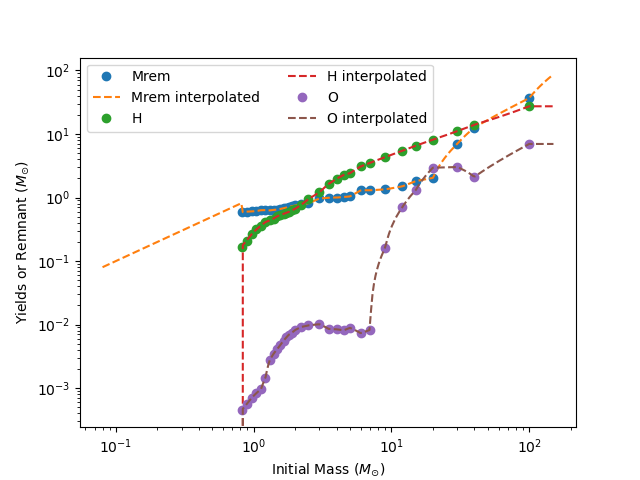

In [50]:
# Plot the original and interpolated yields
key = 'Z=0.004'
df1 = pd.read_csv(os.path.join(out_dir, '%s.csv' % key), index_col=0)
df2 = pd.read_csv(os.path.join(out_dir, '%s_interpolated.csv' % key), index_col=0)
fig, ax = plt.subplots()
index = df1.index
for i in index[[0, 1, 5]]:
    ax.plot(df1.loc[i].index.to_numpy().astype(float), df1.loc[i].values, label=i, linestyle=' ', marker='o')
    ax.plot(df2.loc[i].index.to_numpy().astype(float), df2.loc[i].values, label=i+' interpolated', linestyle='--')
ax.legend(ncol=2)
ax.loglog()
ax.set_xlabel(r'Initial Mass ($M_{\odot}$)')
ax.set_ylabel(r'Yields or Remnant ($M_{\odot}$)')
plt.show()